<a href="https://colab.research.google.com/github/GustaFTW/TensorFlow-ZTM/blob/main/section9_and_milestone2_skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use is available here: https://arxiv.org/abs/1612.05251

**Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to a GPU


In [170]:
!nvidia-smi

Mon Feb 13 14:36:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   3290MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Since we'll be replication the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [171]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [172]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [173]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [174]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [175]:
# Create function to read the lines of a document
def get_lines(filename): 
    """
    Reads filename (a text filename) and returns the lines of text as a list.
    
    Args:
      filename: a string containing the targe filepath.
    

    Returns:
      A list of strings with one string per line from the target filename.
    """

    with open(filename, "r") as f:
        return f.readlines()

In [176]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"/train.txt") # read the lines with the training file

Let's think about how er want our data to look...

How I think our data would be best represented...
```
    [{line_number": 0,
   "target": "BACKGROUND",
   "text": "some string.\n",
   "total_lines: 11},
   ...]
```

In [177]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of a dictionaries of absctract line data.

    Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentence, 
    how many sentences are in the current abstract and what sentence
    number the target line is.
    """
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of absctracts

    # Loop through each line in the target file
    for line in input_lines:
      if line.startswith("###"): #check to see if the line is an ID line
          abstract_id = line
          abstract_lines = "" # reset the abstract string if the line is an ID line
      
      elif line.isspace(): # check to see if line is a new line
          abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
          
          # Iterate through each line in  a single abstract and count them at the same time
          for abstract_line_number, abstract_line in enumerate(abstract_line_split):
              line_data = {} # create an empty dictionary for each line
              target_text_split = abstract_line.split("\t") # split target label from text
              line_data["target"] = target_text_split[0] # get target label
              line_data["text"] = target_text_split[1].lower() # get target text and lower 
              line_data["line_number"] = abstract_line_number # what number line does the line apper in
              line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
              abstract_samples.append(line_data) # add line data to abstract samples list

      else: # if the above conditions aren't fulffiled, the line contains a labelled sentence
          abstract_lines += line
    return abstract_samples


In [178]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 493 ms, sys: 84 ms, total: 577 ms
Wall time: 577 ms


In [179]:
# Check the first abstract of our training tada
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [180]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [181]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

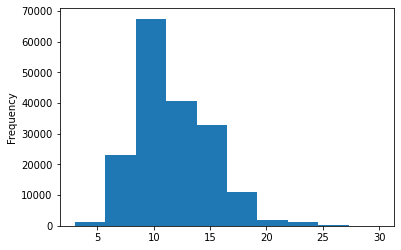

In [182]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [183]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [184]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [185]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))
# check what one hot encoded labels looks like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [186]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [187]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model: 0 Getting a baseline


In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences,
            train_labels_encoded)

KeyboardInterrupt: ignored

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(val_sentences,
              val_labels_encoded)

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

### Download helper functions script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our hlper function script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_preds)
baseline_results

In [ ]:
train_sentences[:10]

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

In [ ]:
# What's the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

### Create text vectorizer layer

We wanto to make a layer which maps our text words in numbers.

In [ ]:
# How many words are in our vocab? (taken from table 2 in the baseline paper) 
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocab
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

In [ ]:
# How many words in our training vocabulary 
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

In [ ]:
# Get the config of our text vecotirzzer
text_vectorizer.get_config()

### Create custom text embedding 

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim=128, # Note: different embedding sizes result in drastically different parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps hare are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile 
model_1.compile(loss="CategoricalCrossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_1.summary()

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              #steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              #validation_steps=int(0.1 * len(valid_dataset)) # only validate on 10% of the valid data
                              ) 

In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

In [ ]:
baseline_results

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifcally the universal sentece encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe megedding, however, we're going to stick with later created USE pre trained embeddings

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:20]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

## Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

# Compile
model_2.compile(loss="CategoricalCrossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_2.summary()

In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

In [ ]:
# Make predictions with feature extraction model
model_2_preds_probs = model_2.predict(valid_dataset)

In [ ]:
# Conver the predictions probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_preds


In [ ]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)
model_2_results

In [ ]:
model_1_results

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level mebddings.

Previously we've made token-level embeddings but we'll need to do similar steps for character if we want to use char-level embeddings.

### Creating a character-lebel tokenizer

In [ ]:
train_characters = []
for sentence in train_sentences:
    for letter in sentence:
        train_characters.append(letter)

print(train_characters[:50])

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}\n")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

## Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of characters
                              output_dim=25, # this is the size of the char embedding in the paper
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n{char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

In [ ]:
len(random_train_chars)

### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

In [ ]:
baseline_results

 ## Model 4: Combining pretrianed token embeddings + characters embeddings (hybrid embedding layer)

 1. Create a token-level embedding model (similar to `model_1`)
 2. Create a character-level model (similar to `model_3` with a slight modification)
 3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
 4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of the paper
 5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as input

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embedding)
token_model = tf.keras.Model(token_inputs,
                             token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in figure 1 of the paper
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense) 
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model iwth char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [ ]:
# Get a summary of our model
model_4.summary()

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token charn model
model_4.compile(loss="CategoricalCrossentropy",
                optimizer="adam", # section 4.2 says they use SGD
                metrics="accuracy")

### Combining token and character data into a tf.data Dataset


In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [ ]:
# Calculate results
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

> **Note:** Any engineered features used to train a model need to be available at test time.

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line-number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot.shape

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers
line_number_inputs = layers.Input(shape=(15), dtype=tf.float32, name="line_number_input")
line_dense = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,
                            line_dense)

# 4. Total Line
total_lines_inputs = layers.Input(shape=(20), dtype=tf.float32, name="total_line_input")
total_lines_dense = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,
                                  total_lines_dense)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)


# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input
                                 ],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
# Get a summary of our tribrid model
model_5.summary()

In [ ]:
# Plot model 5
from keras.utils import plot_model
plot_model(model_5)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not 
consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smotthing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`


In [ ]:
# Compile token, char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

### Create tribrid embedding datasets using tf.data

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above for val dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

### Fitting, evaluating and making predictions with out tribrid model

In [ ]:
# Fit the model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

In [ ]:
# Calculate results of char token pos model
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

## Compare model results


In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## Save and load model

In [ ]:
# Save the best performing model to SavedModel format (default)
model_5.save("smilit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("smilit_tribrid_model")

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)

In [ ]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

In [ ]:
model_5_results == loaded_model_results

## Your challenges

1. Turn the test data samples into a tf.data Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test labels.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild), you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstracts from the wild.
  * Some examples: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
4. See the exercises and extra curriculum section on GitHub to further test your skills (for section 09)

# Milestone 2: SkimLit


## Goals

1. Turn the test data samples into a tf.data Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test labels.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild), you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstracts from the wild.
  * Some examples: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
4. See the exercises and extra curriculum section on GitHub to further test your skills (for section 09)

## Getting our Data

In [ ]:
# Get the data
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# !ls pubmed-rct

In [ ]:
import pandas as pd

# Separate our data properly
test_data = pd.DataFrame(preprocess_text_with_line_numbers("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt"))
test_sentences = test_data["text"]
test_labels = test_data["target"]
test_line_number = test_data["line_number"]
test_total_lines = test_data["total_lines"]
test_chars = list(test_sentences)
test_data.head()

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels.to_numpy())

# Check what training labels look like
test_labels_encoded

In [ ]:
test_labels.value_counts()

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

# One hot encode line number, labels and total lines variables
one_hot = OneHotEncoder(sparse=False)
test_labels_one_hot = one_hot.fit_transform(test_labels.to_numpy().reshape(-1, 1))
test_line_number_one_hot = tf.one_hot(test_line_number.to_numpy(), depth=15)
test_total_lines_one_hot = tf.one_hot(test_total_lines.to_numpy(), depth=20)

# Create a tf.dataset for our data
test_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                test_total_lines_one_hot,
                                                test_sentences, 
                                                test_chars))
test_data_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_data, test_data_labels))

# Prefetch it for better performance
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset

In [ ]:
test_data

> Turn the test data samples into a tf.data Dataset (fast loading) and then *evaluate* (make predictions) the best performing model on the test labels.

In [ ]:
# Predict and get the prediction array
skim_preds_probs = model_5.predict(test_dataset)
skim_preds_probs

In [ ]:
# This will be useful later
skim_preds_max_prob = []
for i, prob in enumerate(skim_preds_probs):
    skim_preds_max_prob.append(float(tf.reduce_max(skim_preds_probs[i])))
len(skim_preds_max_prob)


In [ ]:
# Turn our prediction probabilities into an index of the class predicted
skim_preds = tf.argmax(skim_preds_probs, axis=1)
skim_preds

In [ ]:
# Calculate the results using our previous defined function
calculate_results(test_labels_encoded,
                  skim_preds)

In [ ]:
# Now to fulfill the second goal, we need a dictionary containing the informations of our predictions
pred_dic = {"sentence": test_sentences,
            "target_class": class_names[test_labels_encoded],
            "predicted_class": class_names[skim_preds],
            "predicted_prob": skim_preds_max_prob}
pred_dic = pd.DataFrame(pred_dic)
pred_dic.head()

In [ ]:
# Now we just need a df with only the wrong predictions
wrong_preds = pred_dic[pred_dic["target_class"] != pred_dic["predicted_class"]].sort_values("predicted_prob", ascending=False)

# Done, now we have all the information we need to check our most wrong predictions (higher predicted_prob, for the wrong predicted_class)
wrong_preds.head(20)

## Making prediction on outside data

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

In [ ]:
# Making predictions on more data
lines = get_lines("/content/skimlit_example_abstracts.json")

In [ ]:
# Firs we need to split each sample
sentence = ""
samples = []
for character in lines[0]:
    if character == "}":
      sentence += character
      samples.append(sentence)
      sentence = ""

    elif character == "{":
        sentence = ""
    sentence += character

samples[1]

In [ ]:
# Now we need to split our data into sentences
ex_01_sentences = []
for sentence in samples:
    ex_01_sentences.append(sentence.split("."))

len(ex_01_sentences[3])

In [ ]:
# Creating the example dataset
ex_01_dataset = []
for i, sample in enumerate(ex_01_sentences):
    for j, sentence in enumerate(ex_01_sentences[i]):
        ex_01_sample = {"sentence": ex_01_sentences[i][j],
                        "line_number": (len(ex_01_sentences[i]) - len(ex_01_sentences[i])) + j,
                        "total_line": len(ex_01_sentences[i])}
        ex_01_dataset.append(ex_01_sample)
ex_01_dataset = pd.DataFrame(ex_01_dataset)

> Our dataset is done, but due to missing labels we're not able to predict on this dataset

In [ ]:
ex_01_dataset

# Now onto the extra-curriculum

## Exercises:


Train model_5 on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:

  * tf.keras.callbacks.ModelCheckpoint to save the model's best weights only.
  * tf.keras.callbacks.EarlyStopping to stop the model from training once the validation loss has stopped improving for ~3 epochs.

In [189]:
# Create the callbacks
model_callback_checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/ModelCheckpoints", monitor="accuracy", save_weights_only=True)
model_callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

# Fit the model
model_5.fit(train_char_token_pos_dataset,
            epochs=3,
            steps_per_epoch=int(0.10 * len(train_char_token_pos_dataset)),
            validation_data=val_char_token_pos_dataset,
            validation_steps=int(0.1 * len(val_char_token_pos_dataset)),
            callbacks=[model_callback_checkpoint, model_callback_earlystopping])

Epoch 1/3
562/562 [==============================] - 36s 65ms/step - loss: 0.8956 - accuracy: 0.8672 - val_loss: 0.9138 - val_accuracy: 0.8441
Epoch 2/3
562/562 [==============================] - 36s 64ms/step - loss: 0.8999 - accuracy: 0.8624 - val_loss: 0.9083 - val_accuracy: 0.8561
Epoch 3/3
562/562 [==============================] - 30s 54ms/step - loss: 0.8966 - accuracy: 0.8619 - val_loss: 0.9151 - val_accuracy: 0.8484


Checkout the Keras guide on using pretrained GloVe embeddings. Can you get this working with one of our models?
* Hint: You'll want to incorporate it with a custom token Embedding layer.
* It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.

In [190]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-02-13 14:39:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-13 14:39:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-13 14:39:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [191]:
path_to_glove_file = "/content/glove.6B.100d.txt"


embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [192]:
word_index = dict(zip(rct_20k_text_vocab, range(len(rct_20k_text_vocab))))

In [193]:
num_tokens = len(rct_20k_text_vocab) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 29730 words (35111 misses)


In [194]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

In [195]:
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens= num_tokens,
 output_mode='int',
 output_sequence_length=100)

vectorize_layer.adapt(train_sentences)

In [256]:
# Create a embedding layer for our X_of_Y dataset
embedding_layer_X_of_Y = Embedding(
    num_tokens,
    embedding_dim,
    # embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

vectorize_layer_X_of_Y = tf.keras.layers.TextVectorization(
    max_tokens = num_tokens,
    output_mode="int",
    output_sequence_length=50)
vectorize_layer_X_of_Y.adapt(X_of_Y)

In [196]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = vectorize_layer(inputs) # vectorize text inputs
token_embeddings = embedding_layer(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile 
model_1.compile(loss="CategoricalCrossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 100, 100)          6484300   
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 64)           32064     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 5)                 325 

In [197]:
# Fit the model
model_1.fit(train_dataset,
            epochs=3,
            validation_data=valid_dataset) 

Epoch 1/3
5627/5627 [==============================] - 73s 13ms/step - loss: 0.6496 - accuracy: 0.7640 - val_loss: 0.5633 - val_accuracy: 0.8012
Epoch 2/3
5627/5627 [==============================] - 38s 7ms/step - loss: 0.4916 - accuracy: 0.8276 - val_loss: 0.5361 - val_accuracy: 0.8099
Epoch 3/3
5627/5627 [==============================] - 38s 7ms/step - loss: 0.4240 - accuracy: 0.8527 - val_loss: 0.5364 - val_accuracy: 0.8122


What happens if you were to merge our line_number and total_lines features for each sequence? For example, created a X_of_Y feature instead? Does this effect model performance?

* Another example: line_number=1 and total_lines=11 turns into line_of_X=1_of_11.


In [198]:
train_line_number = train_df["line_number"]
train_total_line = train_df["total_lines"]

In [199]:
print(train_line_number[:13])
print(train_total_line[:13])

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12     0
Name: line_number, dtype: int64
0     11
1     11
2     11
3     11
4     11
5     11
6     11
7     11
8     11
9     11
10    11
11    11
12    10
Name: total_lines, dtype: int64


In [223]:
# Creating the new dataset with X of Y
X_of_Y = []
for i, j in enumerate(train_line_number):
    X_of_Y.append(str(train_line_number[i]) + "_of_" + str(train_total_line[i]))
len(X_of_Y)

180040

In [267]:
# Now, one-hot-encode our data
one_hot_encoder = OneHotEncoder()

# Fitting on the training dataframe 
one_hot_encoder.fit(np.expand_dims(X_of_Y , axis = 1))

# Transforming both train and val df 
train_line_number_total_encoded = one_hot_encoder.transform(np.expand_dims(X_of_Y , axis =1))

# Preparing our dataset to our model
train_line_number_total_encoded = train_line_number_total_encoded.toarray()
train_line_number_total_encoded = tf.cast(train_line_number_total_encoded , dtype= tf.int32)